# AHRS Kalman Filter Qauternion

## AHRS: Quaternion기반 IMU와 magnetometer fusion


- Prediction
    * Gyroscope 출력을 사용하여 변환한 quternion angular rate이용하여 prediction을 수행    
- Update
    * 가속도계에서 측정치를 사용하여 구한 Roll과 Pitch angle을 quaternion 변환하여 measurement update 수행

- State variable
$$
x=
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix}
$$

- Measurement
$$
z=
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix}
$$

## Prediction
- Prediction을 위한 첫 번째 단계는 body에 장착된 gyroscope의 angular rate 측정 $m=[p, q, r]^T$을 quaternion angular reta $x'(x,m)$로 변환하는 것이다.
- 변환을 위해서는 quaternion에 ($x =[q_1, q_2, q_3, q_4]^T$) 에 대한 사전 정보가 필요하다.

$$
x'(x,m)=
\begin{bmatrix}
\dot q_1\\
\dot q_2\\
\dot q_3\\
\dot q_4\\
\end{bmatrix}
=
\frac{1}{2}
\begin{bmatrix}
0&-p&-q&-r\\
p&0&r&-q\\
q&-r&0&p\\
r&q&-p&0\\
\end{bmatrix}
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix}+w
$$

- Euler angle은 quaternion angular rate $x'$를 시간단위로 누적한 후 다시 Euler angle로 변환함으로써 구할 수 있다.
- Quaternion을 discrete time system equation으로 나타내면,
    * 이전 시간의 quaternion $x_{t-1}$에 현재 시점에 구한 quaternion $x_t$을 누적하는 것으로 나타낼 수 있다.
    * 여기서 현재 시점의 quaternion은 gyroscope의 출력을 사용하여 구한 quaternion angular rate $x'(x_{t-1}, m_t)$에 샘플 주기 $T_s$를 곱해서 구할 수 있다.
- Discrete time system equation은 다음과 같이 나태낼 수 있다.

$$
\begin{aligned}
x_{t} &= (x_{t-1} +x'(x_{t-1},m_t) T_s)\\
&=
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix}_{t-1}
+
\frac{T_s}{2}
\begin{bmatrix}
0&-p&-q&-r\\
p&0&r&-q\\
q&-r&0&p\\
r&q&-p&0
\end{bmatrix}
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix}_{t-1}
+w_tT_s\\
&= 
\left(I+
\frac{T_s}{2}
\begin{bmatrix}
0&-p&-q&-r\\
p&0&r&-q\\
q&-r&0&p\\
r&q&-p&0
\end{bmatrix}
\right)
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix}_{t-1}
+ w_tT_s\\
&=G(m_t,T_s)x_{t-1}+w_tT_s\\
&\approx G(m_t,T_s)x_{t-1}+w_t\\\\
x_t &=Gx_{t-1}+w_t
\end{aligned}
$$

- System equation에 의해 구해진 quaternion $x_t$는 system noise에 의해 true값을 알 수 없으며, $x_t \sim \mathcal N(\bar \mu_t, \bar \Sigma_t)$로 나타낸다.
- Prediction 단계에서 구하려고 하는 것은 system equation을 사용하여 현시점의 
    * normal distribution의 평균인 $\bar \mu_t$와 분산인 $\bar \Sigma_t$를 구하려고 한다.
- 여기서 prediction의 평균 $\bar \mu_t$와 분산 $\bar\Sigma_t$는 다음과 같이 구할 수 있다.


$$
\begin{aligned}
\bar \mu_t = G\mu_{t-1}\\
\bar \Sigma_t = G\Sigma_{t-1}G^T+Q
\end{aligned}
$$


- Prediction의 평균 $\bar \mu_t$은 현시점의 system equation의 평균이며 $\mu_{t-1}$은 이전 단계의 평균을 의미 한다.
- Prediction 단계의 분산 $\bar\Sigma_t$은 이전 단계의 분산 $G\Sigma_{t-1}G^T$과 system noise에 의한 system noise coavriance $Q$가 더해진 형태로 구할 수 있다.
- Prediction 단계의 분산 $\bar \Sigma_t$를 구하기 위해서 system noise covariance $Q$가 정의 되어야 한다.
- System equation의 noise $w=[w_{q1}, w_{q2}, w_{q3},w_{q4}]^T$는 system model에 대한 uncertainty를 나타내는 것으로 $w\sim \mathcal N(0, \sigma_{w}^2)$의 normal distribution을 따른다.
- System model은 gyroscope 출력을 사용하여 quaternion을 예측하는 것으로 gyroscope의 측정 오차 성분으로 이의 variance를 모델링 가능하다. 
- Gyroscope의 오차 성분은 angular randomwalk로 말할 수 있으며, $w$의 standard deviation인 $\sigma_{w}$는 ARW 성분으로 modeling 가능하다.
    * ARW는 $deg/\sqrt{h}$의 단위로 나타내며, $ARW=\sigma_w$로 가정 할 수 있다. 
    * 예를 들어 $ARW = \sigma_w =0.2 \deg/\sqrt{h}$의 의미는 1시간 동안 0.2도의 orientation error가 있다는 것이며, 
    * 2시간동안에는 $0.2\times\sqrt{2} = 0.2828 \deg$의 orientation error가 있음을 의미한다.
- 따라서 system equation의 noise covariance $Q$은 다음과 같이 정의 할 수 있다.


$$
\begin{aligned}
Q &=
\begin{bmatrix}
\sigma_w^2&0&0\\
0&\sigma_w^2&0\\
0&0&\sigma_w^2\\
\end{bmatrix}\\
&=
\begin{bmatrix}
\deg^2T_s/3600&0&0\\
0&\deg^2T_s/3600&0\\
0&0&\deg^2T_s/3600\\
\end{bmatrix}\\
\end{aligned}
$$

- 여기서,
$$
\begin{aligned}
\sigma_w &\approx \sigma_w T_s\\
&= \frac{\deg}{\sqrt{h}}T_s\\
\sigma_w^2&= \frac{\deg^2}{h}T_s^2\\
&=\frac{\deg^2}{(3600/T_s)}T_s^2\\
&=\frac{\deg^2}{3600}T_s\\
\end{aligned}\\
$$


- 위에서 정의한 system noise coavariance $Q$는 이전 단계의 noise covariance를 고려하지 않았고,
- gyroscope의 noise standard deviation을 quaternion으로 변환 할때의 scale도 고려하지 않았다.
- 따라서 $Q$를 정의할 때 고려되지 않은 불확실성을 'rule of thum'으로 추가 한다.
    * System noise covariance에 대한 튜닝은 'Kalman Filter.ipynb'를 참고 한다.
    
## Measurement update
- Prediction은 system equation에 의한 quaternion을 예측 한다.
- Prediction만 거듭된다면 quaternion의 uncertainty는 gyroscope의 noise의 제곱에 비례하며 증가한다.
- 이러한 uncertainty 줄이기 위해서는 measuremet를 사용하여 prediction을 update 할 수 있는데, 이것을 measurement update라 한다.
- Prediction 단계에서 예측한 quaternion을 update 하기 위해서는 가속도계에서 구한 Euler angle정보를 사용한다.
    * 가속도 정보를 사용한 자세 추정은 시간에 따른 에러의 누적이 없는 장점이 있다. 
    * 가속도 측정치 $a=[a_x, a_y, a_z]^T$를 사용하여 Euler angle을 구하는 것은 'Complementary Filter'를 참고하고,
    * 변환된 Euler angle을 quaternion으로 다시 변환하여 measurement를 형성하게 된다.
- 가속도 측정치를 사용한 Euler angle의 변환은 다음과 같다.

$$
\begin{aligned}
\phi &= \tan^{-1}\frac{a_y}{a_z}=\sin^{-1} \frac{-a_y}{g\cos \theta}\\
\theta &= \tan^{-1} \frac{-a_x}{\sqrt{(a_y^2+a_z^2)}}=\sin^{-1}\frac{a_x}{g}\\
\psi &= 0\\\\
where,\\ g &=  9.79641227572363 m/s^2\\
&\approx 9.81 m/s^2
\end{aligned}
$$

- Euler angle을 quaternion으로 변환은 다음과 같다.
$$
\begin{bmatrix}
q_1\\
q_2\\
q_3\\
q_4
\end{bmatrix}
=
\begin{bmatrix}
\cos{\frac{\phi}{2}}\cos{\frac{\theta}{2}}\cos{\frac{\psi}{2}}+\sin{\frac{\phi}{2}}\sin{\frac{\theta}{2}}\sin{\frac{\psi}{2}}\\
\sin{\frac{\phi}{2}}\cos{\frac{\theta}{2}}\cos{\frac{\psi}{2}}-\cos{\frac{\phi}{2}}\sin{\frac{\theta}{2}}\sin{\frac{\psi}{2}}\\
\cos{\frac{\phi}{2}}\sin{\frac{\theta}{2}}\cos{\frac{\psi}{2}}+\sin{\frac{\phi}{2}}\cos{\frac{\theta}{2}}\sin{\frac{\psi}{2}}\\
\cos{\frac{\phi}{2}}\cos{\frac{\theta}{2}}\sin{\frac{\psi}{2}}-\sin{\frac{\phi}{2}}\sin{\frac{\theta}{2}}\cos{\frac{\psi}{2}}\\
\end{bmatrix}
$$


- Mesaurement에는 센서의 uncertainty를 포함하고 있다. 따라서 measurement equation은 다음과 같이 나타낼 수 있다.

$$
\begin{aligned}
z_t &= h(x_t)+v_t\\
&=Hx_t+v_t\\
&=
\begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&1&0\\
0&0&0&1
\end{bmatrix}
x_t+v_t
\end{aligned}
$$

- Measurement equation은 linear equation이다.
- Measurement equation의 $v_t=[v_{t,q_1},v_{t,q_2},v_{t,q_3},v_{t,q_4}]$는 quaternion $q_1, q_2, q_3, q_4$에 대한 measurement noise이며 $v_t\sim \mathcal N(0, \sigma_v^2)$으로 normal distribution의 분포를 갖는다.
- Measurement를 사용하여 prediction한 결과 $\bar \mu_t, \bar \Sigma_t$를 update하게 되면 update된 결과 또한 normal distrubution을 따르게 된다.
- 따라서 mesurement update의 결과 $x_t$는 $x_t\sim \mathcal N(\mu_t, \Sigma_t)$ normal distribution을 따르게게 된다.
- 이것은 정확한 true $x_t$를 알수 없기 때문에 $x_t$의 평균과 분산을 통해서 $x_t$를 나타내는 것이다. 
- 따라서 measurement update에서 $x_t$에 대한 평균과 분산을 구하게 된다.

$$
\begin{aligned}
\mu_t&=\bar \mu_t + K(z_t-h(\bar \mu_t)) \\
&=\bar \mu_t + K(z_t-H \bar \mu_t))\\
\Sigma_t &= (I-KH)\bar \Sigma_t\\
\end{aligned}
$$

- Measurement update를 통한 업데이트 된 $x_t$의 평균을 구하기 위해서는 Kalman gain $K$를 알아야 한다.
    * Kalman gain $K$는 measurement를 더 신뢰 할것인지 아니면 predition에 대한 더 신뢰 할 것인지를 결정하는 역활을 한다.
    
$$
\begin{aligned}
K = \bar \Sigma_t H^TS^{-1}\\
S = (H\bar \Sigma_t H^T+R)
\end{aligned}
$$

- Kalman gain을 구하기 위해서는 maesurement noise에 대한 covariance $R$을 먼저 정의해야 한다.
- Quaternion은 가속도계 측정치에 의해 변환된 값으로 가속도계 노이즈 특성에 비례한다.   
- 따라서 Measurement noise covariance $R$은 가속도계의 noide 특성을 반영하여 정의 할 수 있다.

$$
R=
\begin{bmatrix}
\sigma_{v}^2&0&0&0\\
0&\sigma_{v}^2&0&0\\
0&0&\sigma_{v}^2&0\\
0&0&0&\sigma_{v}^2\\
\end{bmatrix}
$$


In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *

In [2]:
# Dataset selection
# f_number 
# 1: Example data provided by Magdwich
# 2: Real IMU data provided by Witmotion 
# 3: IMU data provided by Understanding Kalman filter
f_number = 3

if f_number == 1:
    # Example Data
    ExData1 = loadmat('..\Data\ExampleData.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    time = ExData1['time']
    Ts = time[1]-time[0]
    
    # System model noise covariance
    Q = np.zeros((4,4))
    Q[0, 0] = 1     # Roll angle uncertainty
    Q[1, 1] = 1     # Pitch angle uncertainty
    Q[2, 2] = 1     # Yaw angle uncertainity
    Q[3, 3] = 1     # Yaw angle uncertainity

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 0.01      # Accelerometer measurement uncertainty
    R[1, 1] = 0.01      # Accelerometer measurement uncertainty
    R[2, 2] = 0.01      # Magnetometer measurement uncertainity    
    R[3, 3] = 0.01      # Magnetometer measurement uncertainity    
    
    mu0 = np.array([1.0, 0.0, 0.0, 0.0])
    sigma0 = np.eye((4))
    
    Ts = time[1]-time[0]
    totalLen = Accelerometer.shape[0]
    
elif f_number ==2:

    # Example Data
    ExData1 = loadmat('..\Data\WitMotion_IMU_Data.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    Euler_Truth = ExData1['Euler']
    time = np.array([0, 1])
    Ts = time[1]-time[0]
  
    Q = np.zeros((4,4))
    Q[0, 0] = 1
    Q[1, 1] = 1
    Q[2, 2] = 1
    Q[3, 3] = 1

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 10
    R[1, 1] = 10
    R[2, 2] = 10
    R[3, 3] = 10
    
    mu0 = euler_to_quaternoin(Gyroscope[0,:])
    sigma0 = np.eye((4))
    
    Ts = 1
    totalLen = Accelerometer.shape[0]
    
else:
    ArsAccel = loadmat('..\Data\ArsAccel.mat')
    ArsGyro = loadmat('..\Data\ArsGyro.mat')
    
    Gyroscope = np.zeros((41500, 3))
    Accelerometer = np.zeros((41500, 3))
    
    Gyroscope[:,0] = ArsGyro['wx'][:,0]
    Gyroscope[:,1] = ArsGyro['wy'][:,0]
    Gyroscope[:,2] = ArsGyro['wz'][:,0]
    
    Accelerometer[:,0] = ArsAccel['fx'][:,0]
    Accelerometer[:,1] = ArsAccel['fy'][:,0]
    Accelerometer[:,2] = ArsAccel['fz'][:,0]    
    
    time = 0.01 * np.array([0, 1])
    Ts = time[1]-time[0]
        
    # System model noise covariance
    
    Q = np.zeros((4,4))
    Q[0, 0] = 0.0001
    Q[1, 1] = 0.0001
    Q[2, 2] = 0.0001
    Q[3, 3] = 0.0001

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 10
    R[1, 1] = 10
    R[2, 2] = 10
    R[3, 3] = 10
       

    mu0 = np.array([1.0, 0., 0., 0.])
    sigma0 = np.eye((4))
    
    Ts = 0.01
    totalLen = 41500

In [3]:
# System function
def g_q(mu, Gyroscope, Ts):
    
    wx = Gyroscope[0]
    wy = Gyroscope[1]
    wz = Gyroscope[2]
    
    Omega = np.array([[0.0,-wx, -wy, -wz],[wx, 0.0, wz, -wy],[wy, -wz, 0.0, wx],[wz, wy, -wx, 0.0]])   
        
    # Quaternion rate
    dot_q = (1.0/2.0)*(Omega)   
    
    q = I + dot_q *Ts        
       
    return q

In [4]:
n_x = 4    # number of states

H = np.eye((n_x))
I = np.eye((n_x))

# State variable for mean
mu = np.zeros((n_x))                   # mu initialization
mu_hist = np.zeros((totalLen, 3))    # mu history initialization

# System covariance
sigma = np.eye((n_x))                   # sigma initialization
sigma_hist = np.zeros((totalLen, n_x))  # sigma history initialization

# Sensor fusion 결과 확인을 위한 보조 변수들 
angle = np.zeros((n_x))
angle_hist = np.zeros((totalLen, 3))
z_hist = np.zeros((totalLen, 3))

# measurement update True ==> EKF prediction + measurement update
# measurement update False ==> EKF prediction only
measurement_update = True


for i in range(totalLen):
        
    
    if i == 0:        
        mu = mu0
        sigma = 100*sigma0
        
        angle = mu0
    
    # prediction
    A = g_q(mu, Gyroscope[i,:], Ts)
    mu = np.matmul(A, np.transpose(mu))    
    sigma = np.matmul(np.matmul(A, sigma),np.transpose(A)) + Q    
    
    ###########################################################################################
    # 추가적인 기능 확인을 위한 코드
    
    angle = quat_accum(angle, Gyroscope[i,:], Ts)    
    angle_hist[i,:] = quaternion_to_euler(angle)
    
    # Measurement update를 위한 Accelerometer와 Magnetometer를 사용한 Attitude
    if f_number == 3:
        z = attitudemeasure(mu, 1, Accelerometer[i,:])
    else:
        z = attitudemeasure(mu, 2, Accelerometer[i,:], Magnetometer[i,:])   
        
    z_hist[i,:] = z    
    
    # 추가적인 기능확인을 위한 코드
    ##########################################################################################
    
    if measurement_update == True:   
            
        z_q = euler_to_quaternoin(z)

        S = np.linalg.inv(np.matmul(np.matmul(H, sigma),np.transpose(H)) + R)
        K = np.matmul(np.matmul(sigma, H),S)

        # measurement update
        mea = z_q - np.matmul(np.transpose(H), mu)
        mu = mu + np.matmul(np.transpose(K), mea)
        sigma = np.matmul((I - np.matmul(K, H)),sigma)
    
    # State estimation save
    mu = mu / norm(mu)
    mu_hist[i,:] = quaternion_to_euler(mu)

    # Covarinace save
    sigma_hist[i, 0] = np.sqrt(sigma[0,0])
    sigma_hist[i, 1] = np.sqrt(sigma[1,1])
    sigma_hist[i, 2] = np.sqrt(sigma[2,2])    
    sigma_hist[i, 3] = np.sqrt(sigma[3,3])    


Text(0.5, 1.0, 'Attitude by accelerometer and magnetometer')

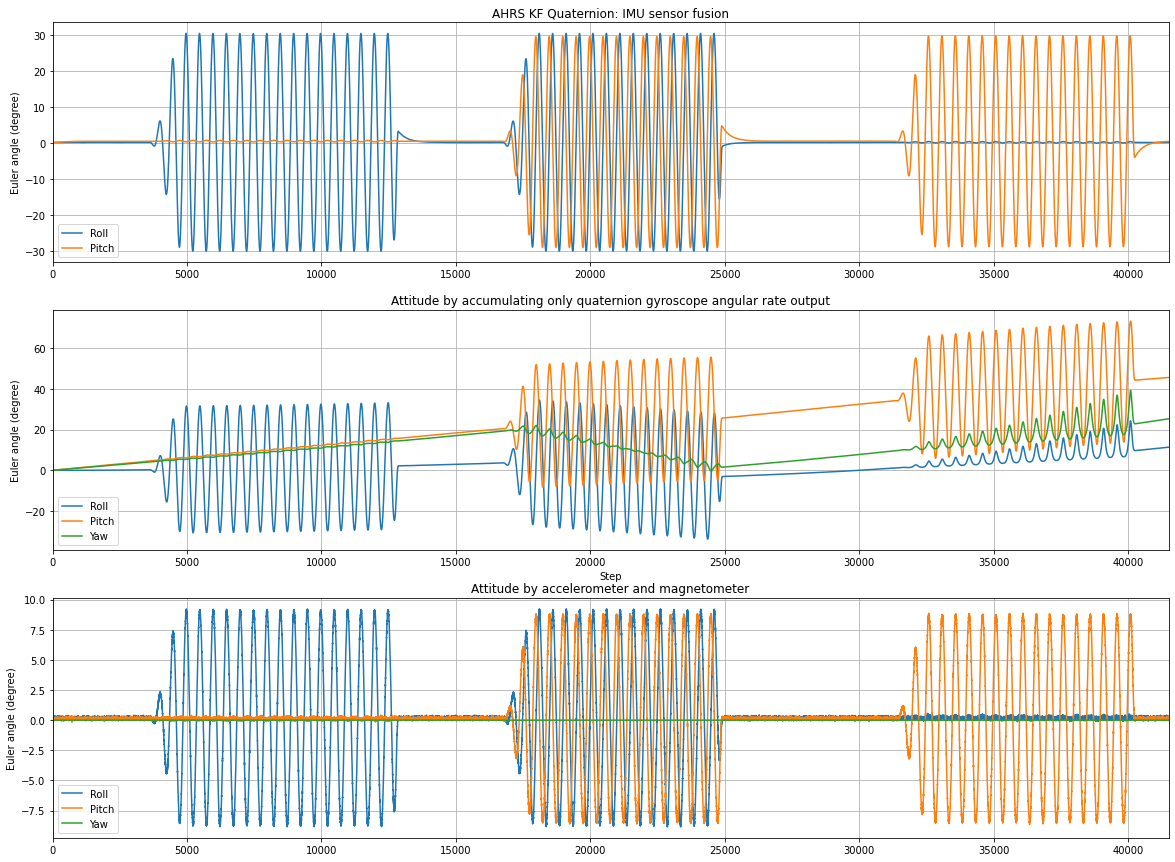

In [5]:
if measurement_update == True:
    title='AHRS KF Quaternion: IMU sensor fusion'
else:
    title='AHRS KF Quaternion: Prediction only'

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)    
if f_number == 3:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist[:,0:2]))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)
else:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)

# Result plotting
plt.subplot(3,1,2)    
plt.plot(np.rad2deg(angle_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accumulating only quaternion gyroscope angular rate output')

# Measurement updat를 위한 accelerometer와 magnatometer의 자세
plt.subplot(3,1,3)    
plt.plot(np.rad2deg(z_hist))
#plt.plot(z_hist)
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accelerometer and magnetometer')

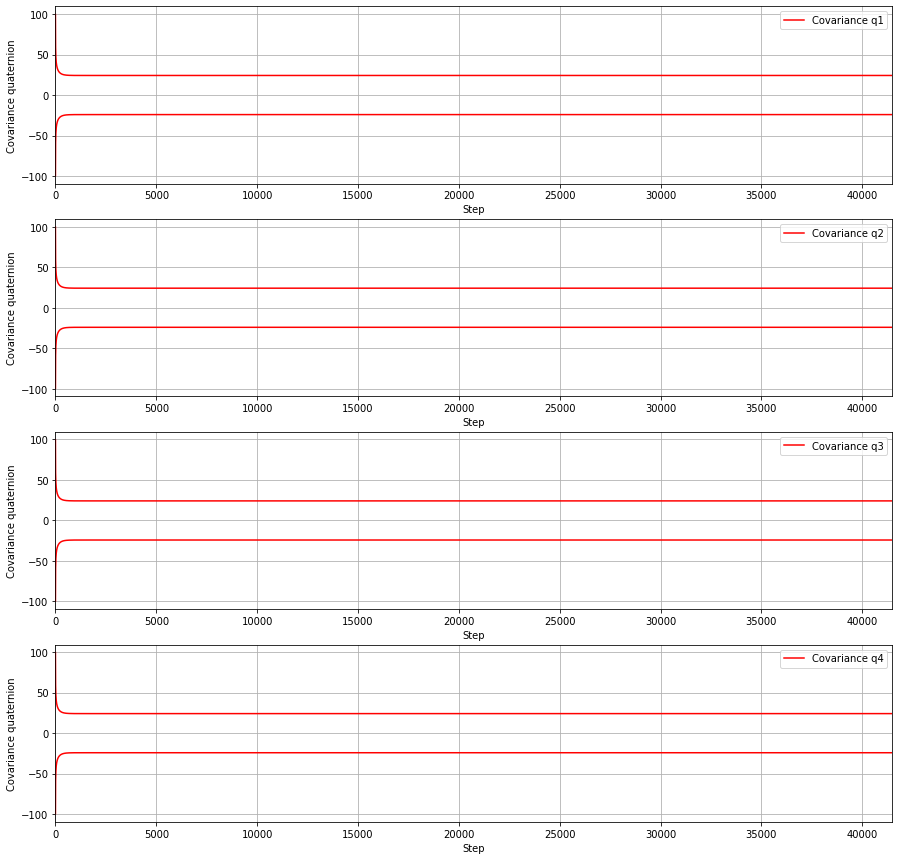

In [6]:
plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,0])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,0])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])
plt.legend(['Covariance q1'])

# Result plotting
plt.subplot(4,1,2)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,1])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,1])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])
plt.legend(['Covariance q2'])

# Result plotting
plt.subplot(4,1,3)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,2])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,2])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])
plt.legend(['Covariance q3'])

# Result plotting
plt.subplot(4,1,4)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,3])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,3])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])
plt.legend(['Covariance q4'])